In [14]:
%%bash
cd ../../../datag/blpd0/datax/Voyager_data
ls

bash: line 1: cd: ../../../datag/blpd0/datax/Voyager_data: No such file or directory


blimpy_voyager.ipynb
test.png


In [20]:
def plot(X, labels, probabilities=None, parameters=None, ground_truth=False, ax=None):
    if ax is None:
        _, ax = plt.subplots(figsize=(10, 4))
    labels = labels if labels is not None else np.ones(X.shape[0])
    probabilities = probabilities if probabilities is not None else np.ones(X.shape[0])
    unique_labels = set(labels)
    colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
    proba_map = {idx: probabilities[idx] for idx in range(len(labels))}
    for k, col in zip(unique_labels, colors):
        if k == -1:
            col = [0, 0, 0, 1]
        class_index = (labels == k).nonzero()[0]
        for ci in class_index:
            ax.plot(
                X[ci, 0],
                X[ci, 1],
                "x" if k == -1 else "o",
                markerfacecolor=tuple(col),
                markeredgecolor="k",
                markersize=4 if k == -1 else 1 + 5 * proba_map[ci],
            )
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    preamble = "True" if ground_truth else "Estimated"
    title = f"{preamble} number of clusters: {n_clusters_}"
    if parameters is not None:
        parameters_str = ", ".join(f"{k}={v}" for k, v in parameters.items())
        title += f" | {parameters_str}"
    ax.set_title(title)
    plt.tight_layout()


signal_power was heavily interfering with clustering 602 -> 292


In [ ]:
import pandas as pd
import numpy as np

features = [
    'signal_frequency',
    'signal_drift_rate',
    'signal_snr',
    'signal_drift_steps',
    'signal_power'
]

pd.set_option('display.max_columns', None)
df = pd.read_pickle("/datag/users/ctremblay/Summer_Project_RA9_Dec0.pkl")
print(df.columns)
df_without_incoherent = df[(df.source_name != 'Incoherent')]
filtered_column_df = df_without_incoherent[features]
small_df = filtered_column_df[100000:103000]
print(small_df.columns)

Index(['id', 'beam_id', 'observation_id', 'tuning', 'subband_offset',
       'file_uri', 'file_local_enumeration', 'signal_frequency',
       'signal_index', 'signal_drift_steps', 'signal_drift_rate', 'signal_snr',
       'signal_coarse_channel', 'signal_beam', 'signal_num_timesteps',
       'signal_power', 'signal_incoherent_power', 'source_name', 'fch1_mhz',
       'foff_mhz', 'tstart', 'tsamp', 'ra_hours', 'dec_degrees',
       'telescope_id', 'num_timesteps', 'num_channels', 'coarse_channel',
       'start_channel'],
      dtype='object')
Index(['signal_frequency', 'signal_drift_rate', 'signal_snr',
       'signal_drift_steps', 'signal_power'],
      dtype='object')


(3000, 5)
602


<Figure size 1000x600 with 0 Axes>

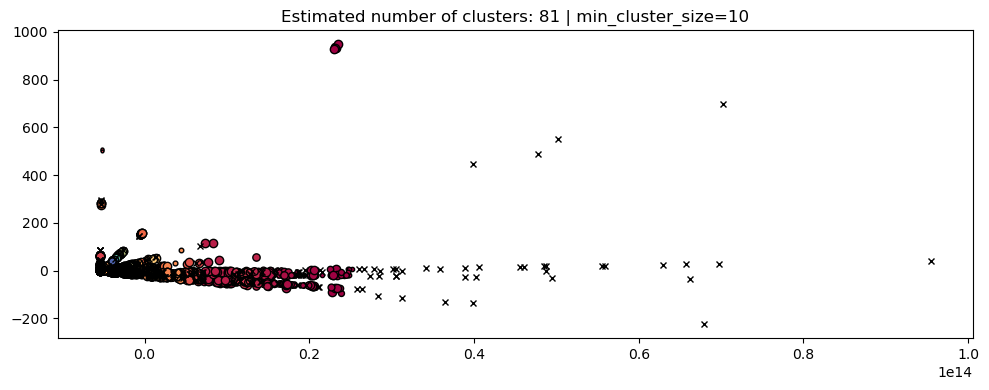

In [19]:
from sklearn.cluster import HDBSCAN
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt


%matplotlib inline
plt.figure(figsize=(10,6))

# 1. Prepare full-dimensional numeric data
X = small_df.select_dtypes(include=[np.number]).fillna(0).values
print(X.shape)

# 2. Fit HDBSCAN
clusterer = HDBSCAN(min_cluster_size=10, n_jobs=-1)
clusterer.fit(X)
labels = clusterer.labels_
probabilities = getattr(clusterer, "probabilities_", None)
print(np.count_nonzero(np.where(labels==-1)))

# 3. Project to 2D for visualization
X_2d = PCA(n_components=2).fit_transform(X)

# 4. Plot clusters
plot(X_2d, labels, probabilities=probabilities, parameters={"min_cluster_size":10})
plt.show()
